<h2>step 1- import needed libraries</h2>

In [1]:
import os
import json
from pathlib import Path
from math import sqrt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)     # to show the all rows
import matplotlib.pyplot as plt
import structure as st
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from transformers import PreTrainedTokenizerFast
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,silhouette_score
from sklearn.cluster import KMeans
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import Lowercase
from datasets import Dataset as HFdataset
from collections import Counter
from IPython.display import display
import seaborn as sns
import umap
import plotly.graph_objects as go
import plotly.io as pio

<h2>Tokenizing process</h2>

<h3>There is no need to rerun the cell below, the pretrained token files have been already prepared in "tokenizers" folder (tokenizer_DNAfile, tokenizer_AAfile or tokenizer_RNAfile).</h3>

In [2]:
# Create the tokenizer
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
# normalize sequences to lowercase
normalizer = Lowercase
tokenizer.normalizer=normalizer() 
#split sequences only in whitespaces
tokenizer.pre_tokenizer = Whitespace()

# Define special tokens
special_tokens_dict = {'pad_token': '[PAD]','unk_token': '[UNK]','sos_token': '[SOS]', 'eos_token': '[EOS]', 'mask_token': '[MASK]'}

# Define the trainer with special tokens
trainer = WordLevelTrainer(special_tokens=list(special_tokens_dict.values()))

# Example training data (the word sources are s.DNA_Codons.keys() , s.RNA_Codons.keys() and s.tobacco_biased.keys())
training_data = st.RNA_Codons.keys()

# Save the training data to a temporary file
with open("training_data.txt", "w") as f:
    f.write("\n".join(training_data))
tokenizer.enable_padding()
tokenizer.train(["training_data.txt"], trainer)
# Save the tokenizer to a file
tokenizer.save("C:\\Users\\farsh\\Downloads\\tokenizer_RNA.json")

<h2>step 2- Directories</h2>

In [3]:
# your current script's directory
base_dir = Path().resolve() 

# use relative paths from base_dir
path_amino = str(base_dir / "data" / "sequence.fasta")
path_dna = str(base_dir / "data" / "sequence.txt")

tokenizer_DNAfile = str(base_dir / "tokenizers" / "tokenizer_DNA.json")
tokenizer_RNAfile = str(base_dir / "tokenizers" / "tokenizer_RNA.json")
tokenizer_AAfile = str(base_dir / "tokenizers" / "tokenizer_aa.json")

checkpoint_dir = str(base_dir / "checkpoints")
path_infer = str(base_dir / "data" / "infer.txt")
path_save_prediction = str(base_dir / "output" / "PREDICTED_seq.fasta")

<h2>step 3- building your own dataset and making it ready for Transformer.</h2>

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer_DNAfile, tokenizer_RNAfile, tokenizer_AAfile,input_length,output_length):
        super().__init__()
        self.data = data
        self.input_length=input_length
        self.output_length=output_length
        self.tokenizer_DNAfile = tokenizer_DNAfile
        self.tokenizer_RNAfile = tokenizer_RNAfile
        self.tokenizer_AAfile = tokenizer_AAfile
        self.tokenized_dataset = self._preprocess_dataset()

    def _tokenize_data(self, data, data_level):
        if data_level == 'DNA':
            fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=self.tokenizer_DNAfile)
            length=self.output_length
        elif data_level == 'RNA':
            fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=self.tokenizer_RNAfile)
            length=self.output_length
        else:
            fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=self.tokenizer_AAfile)
            length=self.input_length
        return fast_tokenizer.batch_encode_plus(data, padding='max_length', return_tensors="pt",max_length=length)

    def _preprocess(self, data):
        model_input = self._tokenize_data(data['input'], data_level='aa')
        labels = self._tokenize_data(data['target'], data_level='DNA')
        model_input['labels'] = labels['input_ids']
        return model_input

    def _preprocess_dataset(self):
        tokenized_dataset = self.data.map(self._preprocess, batched=True, remove_columns=['input', 'target'])
        return tokenized_dataset

    def __len__(self):
        return len(self.tokenized_dataset)

    def __getitem__(self, idx):
        inputs = self.tokenized_dataset['input_ids'][idx]
        labels = self.tokenized_dataset['labels'][idx]
        return torch.tensor(inputs), torch.tensor(labels)
        

<h2>step 4- Subclasses for Encoder and Decoder Layers</h2>

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self,max_position_embeddings,embed_size,dtype=torch.float32,**kwargs):
        super().__init__()
        assert embed_size%2==0, "embed size must be even!"
        p,i=np.meshgrid(np.arange(max_position_embeddings), 2*np.arange(embed_size//2))
        pos_embed=np.empty((1,max_position_embeddings,embed_size))
        pos_embed[0,:,::2]=np.sin(p/10_000**(i/embed_size)).T
        pos_embed[0,:,1::2]=np.cos(p/10_000**(i/embed_size)).T
        self.pos_encodings = torch.tensor(pos_embed, dtype=dtype)
    def forward(self,inputs_ids):
        max_length=inputs_ids.size(1)
        return inputs_ids+self.pos_encodings[:,:max_length]       

class Embeddings(nn.Module):
    """category can be aa (that stands for amino acid),DNA or RNA"""
    def __init__(self,max_position_embeddings,embed_size,vocab_size,dropout,category="aa"):
        super().__init__()
        self.category=category
        self.vocab_size=vocab_size
        self.embed_size=embed_size
        self.max_position_embeddings=max_position_embeddings
        self.token_embeddings=nn.Embedding(self.vocab_size,self.embed_size,padding_idx=0)
        self.position_embeddings=PositionalEmbedding(self.max_position_embeddings,self.embed_size)
        self.layer_norm = nn.LayerNorm(self.embed_size, eps=1e-12)
        self.dropout = nn.Dropout(dropout)
    def forward(self,input_ids):
        token_embeddings = self.token_embeddings(input_ids)
        position_embeddings = self.position_embeddings(token_embeddings)
        embeddings = self.layer_norm(position_embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

def scaled_dot_product_attention(query, key, value,mask=None):
    dim_k=key.size(-1)
    """ for large values of dk (dk is the size of q and k), the dot products grow large in magnitude, pushing the softmax function 
    into regions where it has extremely small gradients. To counteract this effect, we scale the dot products by sqrt(dim_k)
"""
    scores=torch.bmm(query,key.transpose(1,2))/sqrt(dim_k) #This scale (sqrt(dim_k)) was used in the "Attention is All You Need" paper
    if mask is not None:
        mask_matrice=torch.tril(torch.ones(key.size(1),key.size(1))).unsqueeze(0)
        scores=scores.masked_fill(mask_matrice==0,-float("inf"))
    weights=torch.softmax(scores,dim=-1)
    att_output=torch.bmm(weights,value)
    return att_output 

class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
    def forward(self,hidden_state,decoder_state,mask):
        if decoder_state==None:
            #To calculate self_attention for encoder and also masked self_attention for decoder layer (by passing mask=True).
            attn_outputs = scaled_dot_product_attention(self.q(hidden_state), self.k(hidden_state), self.v(hidden_state),mask=mask)
        else:
            #To calculate encoder-decoder attention in decoder layer
            attn_outputs = scaled_dot_product_attention(self.q(decoder_state), self.k(hidden_state), self.v(hidden_state),mask=mask)
        return attn_outputs

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size,num_attention_heads):
        super().__init__()
        embed_dim = embed_size
        num_heads = num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([AttentionHead(embed_dim, head_dim) for _ in range(num_heads)])
    def forward(self, hidden_state,decoder_state,mask):
        x = torch.cat([h(hidden_state,decoder_state,mask) for h in self.heads], dim=-1)
        return x

class AddNorm(nn.Module): 
    """The residual connection followed by a layer normalization."""
    def __init__(self, dropout,embed_size):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(embed_size)

    def forward(self, X, Y):
        return self.ln(X+self.dropout(Y))

class FeedForward(nn.Module):
    def __init__(self, embed_size,intermediate_size):
        super().__init__()
        self.linear_1 = nn.Linear(embed_size, intermediate_size)
        self.linear_2 = nn.Linear(intermediate_size, embed_size)
        self.gelu = nn.GELU()
    def forward(self, x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.linear_2(x)
        return x

<h2>step 5- Encoder and Decoder Layers</h2>

In [6]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_size,num_attention_heads,intermediate_size,dropout):
        super().__init__()
        self.attention = MultiHeadAttention(embed_size,num_attention_heads)
        self.feed_forward = FeedForward(embed_size,intermediate_size)
        self.addnorm = AddNorm(dropout,embed_size) 
        
    def forward(self, inputs):
        x1 = self.attention(inputs,decoder_state=None,mask=None)
        x2=self.addnorm(inputs,x1)
        x3 =self.feed_forward(x2)
        x4=self.addnorm(x2,x3)
        return x4

class TransformerEncoder(nn.Module):
    def __init__(self,num_layers,embed_size,num_attention_heads,intermediate_size,dropout):
        super().__init__()
        self.num_layer=num_layers
        self.encoderLayers=nn.ModuleList([TransformerEncoderLayer(
            embed_size,num_attention_heads,intermediate_size,dropout) for _ in range(self.num_layer)])
    def forward(self,src):
        output=src
        for layer in self.encoderLayers:
            output=layer(output)
        return output
  
class TransformerDecoderLayer(nn.Module):
    def __init__(self,embed_size,num_attention_heads,intermediate_size,dropout):
        super().__init__()
        self.attention = MultiHeadAttention(embed_size,num_attention_heads)
        self.feed_forward = FeedForward(embed_size,intermediate_size)
        self.addnorm = AddNorm(dropout,embed_size)
        self.encoder_decoder_attention = MultiHeadAttention(embed_size,num_attention_heads)
    def forward(self,encoder_output,outputs):
        y2 =self.attention(hidden_state=outputs,decoder_state=None,mask=True)
        y3=self.addnorm(outputs,y2)
        y4 =self.encoder_decoder_attention(hidden_state=encoder_output,decoder_state=y3,mask=None)
        y5=self.addnorm(y3,y4)
        y6 =self.feed_forward(y5)
        y7=self.addnorm(y5,y6)
        return y7

class TransformerDecoder(nn.Module):
    def __init__(self,num_layers,embed_size,num_attention_heads,intermediate_size,dropout):
        super().__init__()
        self.num_layer=num_layers
        self.decoderLayers = nn.ModuleList([TransformerDecoderLayer(
            embed_size,num_attention_heads,intermediate_size,dropout) for _ in range(self.num_layer)])
    def forward(self,memory,tgt,mask=None):
        output=tgt
        for layer in self.decoderLayers:
            output=layer(memory,output)
        return output   

<h2>step 6- Define class for training the model</h2>

In [7]:
class Transformer(nn.Module):
    def __init__(self,
                 batch_size,# based on the experience for codons average length 100-500, it's beeter to be 10% of the number of samples (base two)
                 epochs,
                 embed_size,
                 path_amino=path_amino,
                 path_dna=path_dna,
                 checkpoint_dir=checkpoint_dir, #the best model parameters location to save
                 path_save_prediction=path_save_prediction,
                 tokenizer_DNAfile=tokenizer_DNAfile, #pre_trained tokenized file location
                 tokenizer_RNAfile=tokenizer_RNAfile,
                 tokenizer_AAfile=tokenizer_AAfile,
                 early_stopping_steps=None, #After N steps without improvement, the algorithm will stop.
                 val_size=0.1,
                 test_size=0.1,
                 min_seq_length=0,
                 max_seq_length=float('inf'),
                 num_seq=None,
                 num_attention_heads=2,
                 num_layers=2,
                 dropout=0.2,
                 model_name='best_model.pth'):

        super().__init__()
        self.src_vocab_size=26
        self.tgt_vocab_size=69
        self.batch_size=batch_size
        self.epochs=epochs
        self.embed_size=embed_size
        self.intermediate_size=4*self.embed_size
        self.early_stopping_steps=early_stopping_steps
        self.val_size=val_size
        self.test_size=test_size
        self.min_seq_length=min_seq_length
        self.max_seq_length=max_seq_length
        self.num_seq=num_seq
        self.num_attention_heads=num_attention_heads
        self.num_layers=num_layers
        self.dropout=dropout
        self.model_name=model_name
        self.path_amino=path_amino
        self.path_dna=path_dna
        self.tokenizer_DNAfile=tokenizer_DNAfile
        self.tokenizer_RNAfile=tokenizer_RNAfile
        self.tokenizer_AAfile=tokenizer_AAfile
        self.checkpoint_dir=checkpoint_dir
        self.path_save_prediction=path_save_prediction
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Create data splits
        print('Processing the data...')
        (self.splits, self.num_of_samples, self.input_length, self.output_length,min_raw_seq_length,max_raw_seq_length,min_seq_length,
         max_seq_length,gc_content)=self.__create_dataset(self.path_amino, self.path_dna, self.test_size, self.val_size,self.min_seq_length,
                                                             self.max_seq_length, self.num_seq)
        # Create datasets for each split
        self.train_dataset = CustomDataset(self.splits['train'],self.tokenizer_DNAfile,self.tokenizer_RNAfile,self.tokenizer_AAfile,
                                           self.input_length,self.output_length)
        self.val_dataset = CustomDataset(self.splits['valid'],self.tokenizer_DNAfile,self.tokenizer_RNAfile,self.tokenizer_AAfile,
                                         self.input_length,self.output_length)
        self.test_dataset = CustomDataset(self.splits['test'],self.tokenizer_DNAfile,self.tokenizer_RNAfile,self.tokenizer_AAfile,
                                          self.input_length,self.output_length)
        self.num_of_train_samples=len(self.train_dataset),
        self.num_of_valid_samples=len(self.val_dataset),
        self.num_of_test_samples=len(self.test_dataset),
        print('The data was divided into training, validation, and test sets:')
        print(f'number of the taraining dataset:  {self.num_of_train_samples[0]}')
        print(f'number of the validation dataset: {self.num_of_valid_samples[0]}')
        print(f'number of the test dataset:       {self.num_of_test_samples[0]}')
        print(f'min sequence length of the data:   {min_seq_length} (before filtering: {min_raw_seq_length})')
        print(f'max sequence length of the data:   {max_seq_length} (before filtering: {max_raw_seq_length})')
        print(f'min GC content of the sequences:   {min(gc_content)}%')
        print(f'max GC content of the sequences:   {max(gc_content)}%\n')
        plt.hist(gc_content)
        plt.title('Histogram of GC content')
        plt.xlabel('Gc content percentage %')
        plt.ylabel('number of samples')
        plt.show()
        
        # Create dataloaders
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        self.src_embedding = Embeddings(self.input_length,self.embed_size,self.src_vocab_size,self.dropout,'aa')
        self.tgt_embedding = Embeddings(self.output_length,self.embed_size,self.tgt_vocab_size,self.dropout,'dna')
        self.encoder = TransformerEncoder(self.num_layers,self.embed_size,self.num_attention_heads,self.intermediate_size,self.dropout)
        self.decoder = TransformerDecoder(self.num_layers,self.embed_size,self.num_attention_heads,self.intermediate_size,self.dropout)
        self.fc_out = nn.Linear(self.embed_size,self.tgt_vocab_size)
        self.best_model_path = os.path.join(self.checkpoint_dir, self.model_name)
        self.passed_epoch = 0
        
    def forward(self, src, tgt):
        src_embed = self.src_embedding(src)
        tgt_embed = self.tgt_embedding(tgt)
        memory = self.encoder(src_embed)        
        output = self.decoder(memory,tgt_embed)
        # logits
        return self.fc_out(output)
    def __create_dataset(self,path_amino, path_dna, test_size, val_size, min_seq_length, max_seq_length, num_seq):
        """
            To create your dataset and divide it into Train, Valid and Test set
            
            Args:
            - path_amino: The location of the amino acids file.
            - path_dna:The location of the codons file.
            - test_size:The percentage of your data that should be specified to the test dataset.
            - val_size:The percentage of your data (after decreasing the test data set from it) that should be specified to the validation dataset.
            - min_seq_length:The minimum length of sequence for dataset (default 0)
            - max_seq_length:The maximum length of sequence for dataset (default inf)
            - num_seq:The number of sequence (default None, it means all of your data after considering 
              the min_seq_length and max_seq_length will be considered.)
            
            Returns:
            - dataset,len(aa),input_length,output_length,min_raw_seq_length,max_raw_seq_length,min_seq_length,max_seq_length,gc_content
        """   
        aa = st.fasta_to_list(path_amino, seq_to_codon=False, separate_aa=True, sos_eos=False)
        cds = st.fasta_to_list(path_dna, seq_to_codon=True, separate_aa=False, sos_eos=True)
        length=[len(a.split(' ')) for a in aa]
        min_raw_seq_length=min(length)
        max_raw_seq_length=max(length)
        index_min = [i for i, v in enumerate(length) if v <= min_seq_length]
        index_max = [i for i, v in enumerate(length) if v >= max_seq_length] 
        indices_to_remove = list(set(index_min + index_max))
        aa=np.delete(aa,indices_to_remove) 
        cds=np.delete(cds,indices_to_remove)
        if num_seq!=None:
            aa=aa[:num_seq]
            cds=cds[:num_seq]   
        gc_content=[self.__gc_content(c) for c in cds]
        length=[len(a.split(' ')) for a in aa]
        min_seq_length=min(length)
        max_seq_length=max(length)
        input_length = max(len(seq.split()) for seq in aa)
        output_length = max(len(seq.split()) for seq in cds)
        raw_data = {"input": aa, 'target': cds}
        ds = HFdataset.from_dict(raw_data)
        ds = ds.train_test_split(test_size=test_size)
        valid = ds['train'].train_test_split(test_size=val_size)
        ds['train'] = valid['train']
        ds['valid'] = valid['test']
        return ds,len(aa), input_length, output_length,min_raw_seq_length,max_raw_seq_length,min_seq_length,max_seq_length,gc_content

    def train_model(self,optimizer,criterion):
        num_epochs = self.epochs
        best_val_loss = float('inf')
        os.makedirs(checkpoint_dir, exist_ok=True)
        train_loss_values=[]
        valid_loss_values=[]
        train_acc_values=[]
        valid_acc_values=[]
        early_stopping=0
        lr=[]
        print('Training is beginning...')
        # Training loop
        for epoch in range(num_epochs):
            self.train()
            total_train_loss = 0
            total_train_correct=0
            total_train_masked_length=0
            self.passed_epoch+=1
            for src, tgt in self.train_dataloader:  #for each batch
                src, tgt = src.to(self.device), tgt.to(self.device)
                tgt_input = tgt[:, :-1]
                tgt_output = tgt[:, 1:]
                optimizer.zero_grad()
                output = self(src, tgt_input)
                loss = criterion(output.view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                batch_accuracy,correct,masked_length = self.masked_accuracy(tgt_output,output,pad_token_id=0)
                total_train_correct+=correct
                total_train_masked_length+=masked_length 
            accuracy_train=total_train_correct / total_train_masked_length  
            avg_train_loss = total_train_loss / len(self.train_dataloader)
            # Validation step
            avg_val_loss, accuracy_valid =self.test(self.val_dataloader, criterion)
            scheduler.step(avg_val_loss)
            #append data to plot.
            train_loss_values.append(avg_train_loss)
            valid_loss_values.append(avg_val_loss)
            train_acc_values.append(accuracy_train)
            valid_acc_values.append(accuracy_valid)
            if scheduler.get_last_lr()[0]<optimizer.param_groups[0]['lr']:
                print(f'The learning rate changed to {scheduler.get_last_lr}')
            lr.append(scheduler.get_last_lr()[0])
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Loss: {avg_train_loss:.4f}, '
                  f'Train Accuracy: {accuracy_train*100:.2f}%, '
                  f'Validation Loss: {avg_val_loss:.4f}, '
                  f'Validation Accuracy: {accuracy_valid*100:.2f}%')        
            # Save the best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss 
                self.save_checkpoint(epoch+1, optimizer, avg_val_loss, self.best_model_path)
                early_stopping=0
                schedule_lr=0
                print(f'The Best model saved at epoch {epoch+1}')
            else:
                early_stopping+=1

            if early_stopping==self.early_stopping_steps:
                print(f'***Early stopping in epoch {epoch+1}***')
                break                       
        return train_loss_values, valid_loss_values, train_acc_values, valid_acc_values, lr
    
    # Evaluation function
    def test(self, test_dataloader, criterion):
        self.eval()
        total_test_loss = 0
        total_test_correct = 0
        total_test_masked_length = 0
        with torch.no_grad():
            for src, tgt in test_dataloader:  # for each test batch
                src, tgt = src.to(self.device), tgt.to(self.device)
                tgt_input = tgt[:, :-1]
                tgt_output = tgt[:, 1:]
                output = self(src, tgt_input)
                loss = criterion(output.view(-1, output.size(-1)), tgt_output.contiguous().view(-1))
                total_test_loss += loss.item()
                batch_accuracy, correct, masked_length = self.masked_accuracy(tgt_output, output, pad_token_id=0)
                total_test_correct += correct
                total_test_masked_length += masked_length
    
        avg_test_loss = total_test_loss / len(test_dataloader)
        accuracy_test = total_test_correct / total_test_masked_length
        return avg_test_loss, accuracy_test, 
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy_test:.4f}')

    # Define the inference function
    def infer(self, path_infer,start_token_id=2,output_level='DNA',codons_percentage=True,codon_biased=None,sample_nucloeus=False,nucleus_threshold=0.9):      
        """
        Predict the codon related to the specified protein.
    
        Args:
        - path_infer: The address of your protein FASTA format.
        - start_token_id: it is the 'sos_token' (e.g., '[SOS]') number in the Tokenizing process section (Default is 2).
        - output_level: type of codons that the algorithm has beed trained based on it, (e.g., 'DNA' or 'RNA').
        - codons_percentage: if True, the percentage of each codons related to an amino acid will be printed.
        - codon_biased: a dictionary type of the organism codon biased for further use (ex.  tobacco_biased={'F':'UUU','L':'CUU','I':'AUU',...}
        - sample_nucleous: if True, change the stratefy of selecting next token based on the nucleous sampling method.
        - nucleus_threshold: if sample_nucleous True, a threshold should be assigned, default=0.9
    
        Returns:
        - predicted codon and some other useful information related to the predicted codon, like GC content.
        """
        if output_level=='DNA':
            tokenizer = Tokenizer.from_file(tokenizer_DNAfile)
        else:
            tokenizer = Tokenizer.from_file(tokenizer_RNAfile)
        self.eval()
        infer_data = st.fasta_to_list(path_infer, seq_to_codon=False, separate_aa=True, sos_eos=False)
        fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_AAfile)
        src=fast_tokenizer.encode(infer_data[0],padding='max_length', return_tensors="pt",max_length=self.input_length)
        max_length=torch.count_nonzero(src).item()
        with torch.no_grad():
            src_embed = self.src_embedding(src)
            memory = self.encoder(src_embed)
            tgt_input = torch.LongTensor([[start_token_id]])
            output_sequence = [start_token_id]
            for _ in range(max_length):
                tgt_embed = self.tgt_embedding(tgt_input)
                decoder_output = self.decoder(memory, tgt_embed)
                output_logits = self.fc_out(decoder_output[:, -1, :])
                next_token = output_logits[0].argmax(dim=-1).item() # Greedy algorithm
                if sample_nucloeus: # Nucleous sampling algorithm
                    next_token=nucleous_sampling(output_logits,threshold)            
                output_sequence.append(next_token)
                tgt_input = torch.cat((tgt_input, torch.LongTensor([[next_token]])), dim=1)
        codon=tokenizer.decode(output_sequence[1:], skip_special_tokens=False).upper()
        # Create the content in FASTA format
        fasta_content = f">Predicted Sequence\n{codon.replace(' ','')}\n"
        # Write the string to the text file
        with open(path_save_prediction, 'w') as file:
            file.write(fasta_content)
        gc_content=self.__gc_content(codon,sep=' ')
        wrong_codon_num,index_num=self.__mapcodon(infer_data[0],codon)
        infer_sep=infer_data[0].split(' ')
        codon_sep=codon.split(' ')
        for i in index_num:
            codon_sep[i]='\033[91m'+codon_sep[i]+"("+infer_sep[i].upper()+")"+ '\033[0m'
        codon_sep=' '.join(codon_sep)
        print(f'PREDICTED Codon:\n {codon_sep}\n')        
        print(f"The predicted codon sequence has been saved in {path_save_prediction}")
        print('-'*50)
        print(f'GC content: {gc_content}%')
        print('-'*50)
        print(f'The number of codons that mapped wrongly to an amino acid (marked in red): {wrong_codon_num} of {len(codon.split(' '))}')
        print(f'accuracy percentage of mapped codons: {round((1-wrong_codon_num/len(codon.split(' ')))*100,2)}%')
        print('-'*50)
        if codons_percentage:
            self.__codons_percentage(infer_data[0],codon,index_num,codon_biased)
        return codon

    def masked_accuracy(self,label, pred, pad_token_id=0):
        """
        To calculate the masked accuracy.
    
        Args:
        - label (torch.Tensor): Ground truth labels with padding.
        - pred (torch.Tensor): Predictions from the model (logits).
        - pad_token_id (int): The id used for padding.
    
        Returns:
        - The masked accuracy value.
        - number of matches
        - numer of labels which is not equal to zero.
        """
        pred = pred.argmax(dim=-1)
        mask = label != pad_token_id
        match = (label == pred) & mask
        match = match.float()
        mask = mask.float()
        accuracy = match.sum() / mask.sum()
        return accuracy.item(),match.sum().item(),mask.sum().item()
        
    def __codons_percentage(self,aa, cds,index_num, codon_biased=None,sep=' '):
        """To calculate and display the percentage of each amino acid codon selected by algorithm. if you define a codon biased dictionary,
        the codon-biased related to an amono acid will be marked."""
        cds = cds.split(sep)
        aa = aa.split(sep)
        dict_aa = {}
        dict_bb = {}
        percentages = {}
        # Convert codon biased in DNA format
        if codon_biased is not None:
            for i in codon_biased.values():
                if 'U' in i:
                    codon_biased = {key: value.replace('U', 'T') for key, value in tobacco_biased.items()}
                    break
        for i, v in enumerate(list(aa)):
            if v in dict_aa:
                if i in index_num:
                    dict_aa[v].append(cds[i]+'_')
                else:
                    dict_aa[v].append(cds[i])
            else:
                if i in index_num:
                    dict_aa[v] = [cds[i]+'_']
                else:
                    dict_aa[v] = [cds[i]]
            if (codon_biased is not None) and cds[i] == codon_biased.get(v, None):
                dict_aa[v][-1] = '*' + cds[i]
        for k, v in dict_aa.items():
            dict_bb[k] = Counter(v)    
        # Calculate the percentage of each codon relative to its amino acid
        for amino_acid, codons in dict_bb.items():
            total_count = sum(codons.values())
            percentages[amino_acid] = {codon: (count / total_count) * 100 for codon, count in codons.items()}      
        print('Percentage of selected codons for each amino acid:')              
        print('*: biased codon', end='\n\n')
        rows = []
        for key, subdict in percentages.items():
            for subkey, value in subdict.items():
                formatted_value = np.round(value,2)
                rows.append({'Amino acid': key, 'Codon': subkey, 'Participation percentage %': formatted_value})
        # Create DataFrame
        df = pd.DataFrame(rows)
        df=df.sort_values(['Amino acid','Participation percentage %'],ascending=[True,False]).reset_index(drop=True)
        df2 = df.style.map(lambda v: 'color: red;' if isinstance(v, str) and v.endswith('_') else '').format({"Participation percentage %" : "{:.2f}"})
        display(df2)
        
    def __gc_content(self,seq,sep=' '):
        '''To calculate the GC content in a DNA/RNA sequence'''
        seq=seq.replace(sep,"")
        return round((seq.count('C')+seq.count('G'))/len(seq)*100)
        
    def __mapcodon(self,amino,codon,sep=' '):
        """To calculate if each predicted codon is the right codon for the specified amino acid"""
        count=0
        index=[]
        amino=amino.split(sep)
        codon=codon.split(sep)
        special_tokens=['[PAD]','[UNK]','[SOS]','[EOS]','[MASK]']
        for i,v in enumerate(amino):
            if (codon[i] not in special_tokens) and (v!=st.DNA_Codons[codon[i]]):
                index.append(i)
                count+=1 
        return count, index

    def nucleous_sampling(self,logits,threshold):
        """choose the next token based on the method written in this paper: https://arxiv.org/pdf/1904.09751
        unlike previous methos like greedy search (argmax), top_k or beam search, this method chose the best next token among the smallest list
        that the probability cumulative of their candidates is equal or greater than the specified threshold. """
        cumulative_sum = 0.0
        nucleous_list=[]
        softmax=torch.softmax(logits,dim=-1)[0]
        # tensor_list=torch.softmax(softmax,dim=-1)
        sorted_tensor = sorted(enumerate(softmax), key=lambda x: x[1],reverse=True)
        # Find the index where the cumulative sum exceeds threshold
        for index, (original_index, value) in enumerate(sorted_tensor):
            nucleous_list.append((original_index, value))
            cumulative_sum += value.item()
            if cumulative_sum > threshold:
                break
        rnd=np.random.randint(0,len(nucleous_list))
        return nucleous_list[rnd][0]
        
    def save_checkpoint(self,epoch, optimizer, loss, path):
        state = {
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}
        torch.save(state, path)
        
    def load_checkpoint(self,path,optimizer):
        checkpoint = torch.load(path)
        self.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        return epoch, loss

    #Error analysis function
    def error_analysis(self, data=None, output_level='DNA',norm_cm=None):
        """
        Perform error analysis on the data.
    
        Args:
        - data: The data that was batched using the CustomDataset class.(if None, the model test dataset (test_dataloader) will be assigned)
        - output_level: the type of codons that the algorithm has beed trained based on it, (e.g., 'DNA' or 'RNA') default 'DNA'
        - norm_cm: normalize : {'true', 'pred', 'all'}, default=None
          Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population.
          If None, confusion matrix will not be normalized.
    
        Returns:
        - Sample-accuracy for each quartile (totally four accuracy values for each sequence)
        - Substitution-accuracy that is the accuracy achieved when both relevant codons in the label and prediction correspond to similar amino acids.
          (ex. prediciton codon:"AAT", label codon:"AAC", but because both codons are related to amino acid "N", it is considered True for calculating
          the accuracy metric value. in the sample accuracy or accuracy value during training process it is considered False)
        - Substitution_accuracy_mean that is the total average of the Substitution-accuracy value.
        - cf_matrix that is the confusion matrix
        
        * Substitution-accuracy and Substitution_accuracy_mean are presented as one tuple (e.g., (Substitution-accuracy, Substitution_accuracy_mean))
          example:
          sample_acc,substitution,cf_matrix = model.error_analysis()
          substitution[0] => Substitution-accuracy
          substitution[1] => Substitution_accuracy_mean

        * at the end of the process analysis a heatmap diagram for average accuracy value of each quartile, the confusion matrix table and
          the precision,recall and F1_score table for each amino acid will be plotted.
          
        """     
        self.eval()
        samples_accuracy=[]
        substitution_accuracy=[]
        confusion_dict={}
        y_true=[]
        y_pred=[]
        if data is None:
            data=self.test_dataloader
        if output_level=='DNA':
            tokenizer = Tokenizer.from_file(tokenizer_DNAfile)
        else:
            tokenizer = Tokenizer.from_file(tokenizer_RNAfile)
        with torch.no_grad():
            for src, tgt in data:  # for each test batch
                src, tgt = src.to(self.device), tgt.to(self.device)
                tgt_input = tgt[:, :-1]
                tgt_output = tgt[:, 1:]
                output = self(src, tgt_input)
                #calculate quartile accuracies
                for target,pred in zip(tgt_output,output): 
                    #because each sample has different pad_token length so for calculating the quartiles we have to analyze each sample one bat a time
                    true_indices = torch.where(target != 0)[0]
                    length = len(true_indices)
                    pred=pred.argmax(-1)
                    y_true.append(target)
                    y_pred.append(pred)
                    if length == 0:
                        continue  # skip if there are no true values
                    quartile_indices = [int(length * p) for p in [0.25, 0.50, 0.75, 1.00]]
                    accuracies = []
                    start_idx = 0
                    for end_idx in quartile_indices:
                        pred_quartile = pred[start_idx:end_idx]
                        target_quartile = target[start_idx:end_idx]
                        match_quartile = (pred_quartile == target_quartile)
                        accuracy = torch.sum(match_quartile).float() / len(match_quartile)
                        accuracies.append(accuracy.item())
                        start_idx = end_idx
                    samples_accuracy.append(accuracies)
                    # calculate substitution accuracy
                    false_pred=(pred!=target) & (target!=0)
                    mask=(target!=0)
                    match = (target == pred) & mask
                    substitution_match=0
                    for i,is_false in enumerate(false_pred):
                        if is_false: # [EOS] token is 3
                            codon_pred=tokenizer.decode([pred[i]], skip_special_tokens=True).upper()
                            codon_label=tokenizer.decode([target[i]], skip_special_tokens=True).upper()
                            if codon_pred!='':
                                amino_pred=st.DNA_Codons[codon_pred]
                            if codon_label!='':
                                amino_label=st.DNA_Codons[codon_label]
                            if amino_pred==amino_label:
                                substitution_match+=1
                    for i in range(torch.argmin(target)):
                        if target[i].item() not in confusion_dict.keys():
                            confusion_dict[target[i].item()]=[pred[i].item()]
                        else:
                            confusion_dict[target[i].item()].append(pred[i].item())
                        

                    substitution_accuracy.append(((match.sum()+substitution_match)/mask.sum()).item())
                    substitution_accuracy_mean=torch.tensor(np.mean(substitution_accuracy))
        samples_accuracy=torch.tensor(samples_accuracy)
        samples_accuracy_mean=torch.mean(samples_accuracy,dim=0).unsqueeze(0)
        # Create a heatmap
        plt.figure(figsize=(6, 4))
        heatmap = sns.heatmap(samples_accuracy_mean, annot=True, cmap="YlGnBu", cbar=True, 
                              xticklabels=['Quartile 1', 'Quartile 2', 'Quartile 3', 'Quartile 4'])
        heatmap.set_yticklabels([]) # Remove y-axis label (0) by setting it to an empty string
        plt.title('Average accuracy of Each Quartile')
        print(f'plotting the average accuracy of Each Quartile...')
        plt.show()  
        #plot confusion matrix
        y_true=np.ravel(y_true)
        y_pred=np.ravel(y_pred)
        filt=np.where(y_true!=0)
        y_true_filtered=y_true[filt]
        y_pred_filtered=y_pred[filt]
        cf_matrix = confusion_matrix(y_true_filtered,y_pred_filtered,normalize=norm_cm)
        labels = [tokenizer.decode([i],skip_special_tokens=False).upper() for i in np.unique(y_true_filtered)]
        ticks=np.linspace(0, len(labels),num=len(labels))
        plt.figure(figsize=(15, 12))
        plt.imshow(cf_matrix, interpolation='none', cmap='Blues')
        plt.colorbar()
        plt.xticks(ticks, labels, fontsize=8, rotation=90)
        plt.gca().xaxis.set_ticks_position('top')
        plt.xlabel('Predicted')
        plt.yticks(ticks, labels, fontsize=8)
        plt.ylabel('Actual')
        if norm_cm=='true':
            plt.title('Confusion matrix (Normalized over the true (rows))')
        elif norm_cm=='pred':
            plt.title('Confusion matrix (Normalized over the predicted (columns))')
        elif norm_cm=='all':
            plt.title('Confusion matrix (Normalized over the all the population)')
        else:
            plt.title('Confusion matrix')
        print(f'\nplotting confusion matrix...')
        plt.show()
        
        #plot precisin, recall, F1_score table
        prf=precision_recall_fscore_support(y_true_filtered,y_pred_filtered,zero_division=0)
        reshaped_prf = [np.round(array.reshape(-1, 1),2) for array in prf]
        stacked_arrays = np.hstack([np.array(labels).reshape(-1,1)] + reshaped_prf)
        prf_df=pd.DataFrame(stacked_arrays,columns=['Amino acid','Precision','Recall','F1-score','Count'])
        prf_df.sort_values(by='Recall',inplace=True,ascending=False)
        print(f'\nplotting precisin, recall, F1_score table (sorted descending by recall)...')
        print(f'* Precision means how many percentage of the predicted values for that amino acid was predicted correctly')
        print(f'* Recall means how many percentage of the specific amino acid was predicted correctly')
        print(f'* F1-score is the harmonic average of the precision and recall values')
        print(f"**The index numbers correspond to the rows of the confusion matrix for the relevant codons; that's why they have not been reset^^\n")
        display(prf_df)
        return samples_accuracy,(torch.tensor(substitution_accuracy),substitution_accuracy_mean),cf_matrix
        
    def plot_umap(self,src_embeddings,tgt_embeddings,n_neighbors=15,aa_clusters_num=3,cds_clusters_num=10,aa_index=6,cds_index=5):
        """
        A method for plotting the dependency among codons and amino acids using the UMAP method to reduce the dimension of embeddings.
    
        Args:
        - src_embeddings: extract the final src_embedding from the saved file in checkpoint_dir
                                                                        (model.state_dict()['src_embedding.token_embeddings.weight'])
        - tgt_embeddings: extract the final tgt_embedding from the saved file in checkpoint_dir
                                                                        (model.state_dict()['tgt_embedding.token_embeddings.weight'])
        - n_neighbors: The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
          Larger values result in more global views of the manifold, while smaller values result in more local data being preserved.
          In general values should be in the range 2 to 100, default=15
        - aa_clusters_num: Amino acids cluster numbers, default=3
        - cds_clusters_num: Codons cluster numbers, default=10
        - aa_index: to exclude tokens that are not amino acids before this index ("[PAD]:0","[UNK]:1,"[SOS]:2","[EOS]:3","[MASK]:4,"[_]:5"), default=6
        - cds_index: to exclude tokens that are not codons before this index ("[PAD]:0","[UNK]:1,"[SOS]:2","[EOS]:3","[MASK]:4), default=5
        
        Returns:
        - amino_umap,codon_umap (the reduced size of codons and amino acids embeddings)
        """
        src_embeddings=model.state_dict()['src_embedding.token_embeddings.weight']
        tgt_embedding=model.state_dict()['tgt_embedding.token_embeddings.weight']
        # z1,z2=model.get_embeddings(model.train_dataloader)
        reducer_codon = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1,n_components=2)
        reducer_amino = umap.UMAP(n_neighbors=n_neighbors, min_dist=0.1,n_components=2)
        amino_umap = reducer_amino.fit_transform(src_embeddings)
        codon_umap = reducer_codon.fit_transform(tgt_embeddings)
        
        fig, axs = plt.subplots(3, 2, figsize=(20, 15))  # Adjust the figure size as needed
        ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()
        
        #(number 5 and 6 is for jumping the specific tokens)
        ax1.scatter(amino_umap[aa_index:,0], amino_umap[aa_index:,1], s=30, cmap='Spectral',c=np.arange(src_embeddings.shape[0]-aa_index))
        ax1.set_xlabel('UMAP 1')
        ax1.set_ylabel('UMAP 2')
        ax1.set_title('aminos dependency')
        ax1.set_xticks([])
        ax1.set_yticks([])
        self.__annotation_from_json(self.tokenizer_AAfile,ax1,amino_umap,aa_index)
        fig.savefig("umap_amino.png")

        ax2.scatter(codon_umap[cds_index:, 0], codon_umap[cds_index:, 1], s=26, cmap='Spectral',c=np.arange(tgt_embeddings.shape[0]-cds_index))
        ax2.set_xlabel('UMAP 1')
        ax2.set_ylabel('UMAP 2')
        ax2.set_title('Codons dependency')
        ax2.set_xticks([])
        ax2.set_yticks([])
        self.__annotation_from_json(self.tokenizer_DNAfile,ax2,codon_umap,cds_index)
        fig.savefig("umap_codon.png")
        
        kmeans_aa=KMeans(n_clusters=aa_clusters_num, random_state=42)
        amino_umap=amino_umap.astype(np.float64)
        kmeans_aa.fit_predict(amino_umap[aa_index:])
        self._plot_decision_boundaries(kmeans_aa, amino_umap, aa_index, ax3, self.tokenizer_AAfile) 
        ax3.set_title('KMeans Clustering Results for Amino Acids')
        ax3.set_xticks([])
        ax3.set_yticks([])
        self.__annotation_from_json(self.tokenizer_AAfile,plt,amino_umap,aa_index)
        fig.savefig("voronoi_plot_amino.png")
        
        kmeans_cds=KMeans(n_clusters=cds_clusters_num, random_state=42)
        codon_umap=codon_umap.astype(np.float64)
        kmeans_cds.fit_predict(codon_umap[cds_index:])
        self._plot_decision_boundaries(kmeans_cds, codon_umap, cds_index, ax4, self.tokenizer_DNAfile) 
        ax4.set_title('KMeans Clustering Results for Codons')
        ax4.set_xticks([])
        ax4.set_yticks([])
        self.__annotation_from_json(self.tokenizer_DNAfile,plt,codon_umap,cds_index)
        fig.savefig("voronoi_plot_codon.png")

        self.__plot_silhouette(amino_umap,ax5,'amino acids')
        self.__plot_silhouette(codon_umap,ax6,'codons')      
        plt.show()

        #plot interactive Codon_Amino
        with open(model.tokenizer_DNAfile, 'r') as file:
            data = json.load(file)
            vocab_cds = data["model"]["vocab"]
        codons = [k.upper() for k, v in vocab_cds.items() if v >= cds_index]
        aminos = [st.DNA_Codons[c] for c in codons]  # Ensure 'st.DNA_Codons' is defined and imported correctly
        data = {
            'codon': codons,
            'amino_acid': aminos,
            'x': codon_umap[cds_index:,0],  # Ensure 'codon_umap' is defined and available
            'y': codon_umap[cds_index:,1]
        }
        df = pd.DataFrame(data)
        fig = go.Figure()
        # Add traces for each amino acid
        amino_acids = df['amino_acid'].unique()
        for aa in amino_acids:
            df_aa = df[df['amino_acid'] == aa]
            fig.add_trace(go.Scatter(
                x=df_aa['x'], y=df_aa['y'], mode='markers+text', text=df_aa['codon'],
                name=aa, textposition='top center', marker=dict(size=12, opacity=0.8),
                textfont=dict(size=12, color='rgba(0,0,0,0.8)')
            ))
        # Add dropdown buttons
        buttons = []
        for aa in amino_acids:
            visible = [trace.name == aa for trace in fig.data]
            opacity = [1.0 if v else 0.3 for v in visible]
            text_opacity = [1.0 if v else 0.3 for v in visible]
            button = dict(
                label=aa,
                method='update',
                args=[{
                    'marker.opacity': opacity,
                    'textfont.color': [f'rgba(0,0,0,{t})' for t in text_opacity]
                }]
            )
            buttons.append(button)
        # Add a button to show all data
        buttons.append(dict(label='All', method='update', args=[{
            'marker.opacity': [0.8]*len(fig.data),
            'textfont.color': ['rgba(0,0,0,0.8)']*len(fig.data)
        }]))
        # Update layout with buttons
        fig.update_layout(
            title="Interactive Codon-Amino Acid Plot",
            updatemenus=[dict(active=len(buttons)-1, buttons=buttons)]
        )
        fig.show(renderer='iframe')
        return amino_umap,codon_umap
         
    def __plot_centroids(self,centroids,plt, weights=None, circle_color='w', cross_color='k'):
        """plot points of kmean training data kmean.cluster_centers_"""
        if weights is not None:
            centroids = centroids[weights > weights.max() / 10]
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='o', s=35, linewidths=8,
                    color=circle_color, zorder=10, alpha=0.9)
        plt.scatter(centroids[:, 0], centroids[:, 1],
                    marker='x', s=2, linewidths=12,
                    color=cross_color, zorder=11, alpha=1)
    
    def _plot_decision_boundaries(self, clusterer, X, index, plt, tokenfile, resolution=1000, show_centroids=True,show_xlabels=False, show_ylabels=False):
        """colorized zones"""
        mins = X[index:].min(axis=0) - 0.1
        maxs = X[index:].max(axis=0) + 0.1
        xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                             np.linspace(mins[1], maxs[1], resolution))
        # Ensure the meshgrid data is of type float64
        Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
    
        plt.contourf(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),cmap="Pastel2")
        plt.contour(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),linewidths=1, colors='k')
        plt.plot(X[index:, 0], X[index:, 1], 'k.', markersize=2)
        self.__annotation_from_json(tokenfile,plt,X,index)
        
        if show_centroids:
            self.__plot_centroids(clusterer.cluster_centers_,plt=plt)
        if show_xlabels:
            plt.set_xlabel("$x_1$", fontsize=14)
            plt.tick_params(labelbottom=False)
        if show_ylabels:
            plt.set_ylabel("$x_2$", fontsize=14, rotation=0)
            plt.tick_params(labelleft=False)

    def __plot_silhouette(self,data_umap,plt,title):
        """plot silhouette score vs clusters to find the optimum number of clusters"""
        kmeans=KMeans()
        clusters=np.arange(2,11)
        s_scores=[]
        for c in clusters:
            kmeans.n_clusters=c
            kmeans.fit(data_umap)
            s=silhouette_score(data_umap,kmeans.labels_)
            s_scores.append(s)
        plt.plot(clusters,s_scores)
        plt.set_xlabel('k')
        plt.set_ylabel('silhouette score')
        best_k=np.argmax(s_scores)
        plt.set_title(f'Silhouette Scores for {title}')
        plt.scatter(clusters[best_k], s_scores[best_k], color='red', zorder=5) 
        plt.text(clusters[best_k]+0.2, s_scores[best_k], f'the best k={clusters[best_k]}', color='red', fontsize=12, ha='left', va='top')    

    def __annotation_from_json(self,tokenfile,ax,data_umap,index):
        with open(tokenfile, 'r') as file:
            data = json.load(file)   
        vocab_cds = data["model"]["vocab"]
        if index==5:
            fontsize=10
        else:
            fontsize=12
        for i, v in vocab_cds.items():
            if v>=index: #jump from specific tokens
                ax.annotate(i.upper(), (data_umap[v, 0], data_umap[v, 1]), fontsize=fontsize, alpha=0.75)

<h2>step 7- Training and Evaluating the data</h2>

Processing the data...


Map:   0%|          | 0/1620 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

The data was divided into training, validation, and test sets:
number of the taraining dataset:  1620
number of the validation dataset: 180
number of the test dataset:       200
min sequence length of the data:   101 (before filtering: 23)
max sequence length of the data:   499 (before filtering: 5490)
min GC content of the sequences:   32%
max GC content of the sequences:   81%



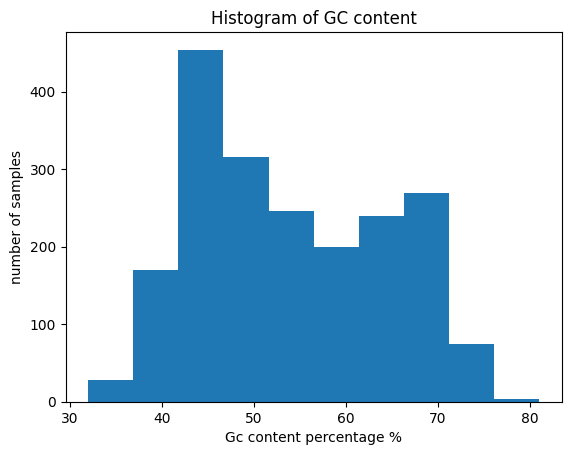

Training is beginning...
Epoch [1/50], Loss: 3.9632, Train Accuracy: 5.41%, Validation Loss: 3.8826, Validation Accuracy: 6.65%
The Best model saved at epoch 1
Epoch [2/50], Loss: 3.8386, Train Accuracy: 6.95%, Validation Loss: 3.8294, Validation Accuracy: 7.57%
The Best model saved at epoch 2
Epoch [3/50], Loss: 3.7733, Train Accuracy: 7.93%, Validation Loss: 3.7118, Validation Accuracy: 9.15%
The Best model saved at epoch 3
Epoch [4/50], Loss: 3.5883, Train Accuracy: 10.81%, Validation Loss: 3.1212, Validation Accuracy: 17.66%
The Best model saved at epoch 4
Epoch [5/50], Loss: 2.6852, Train Accuracy: 25.60%, Validation Loss: 1.1975, Validation Accuracy: 50.09%
The Best model saved at epoch 5
Epoch [6/50], Loss: 1.6659, Train Accuracy: 42.42%, Validation Loss: 1.0646, Validation Accuracy: 52.20%
The Best model saved at epoch 6
Epoch [7/50], Loss: 1.4062, Train Accuracy: 46.86%, Validation Loss: 1.0358, Validation Accuracy: 52.99%
The Best model saved at epoch 7
Epoch [8/50], Loss: 1.

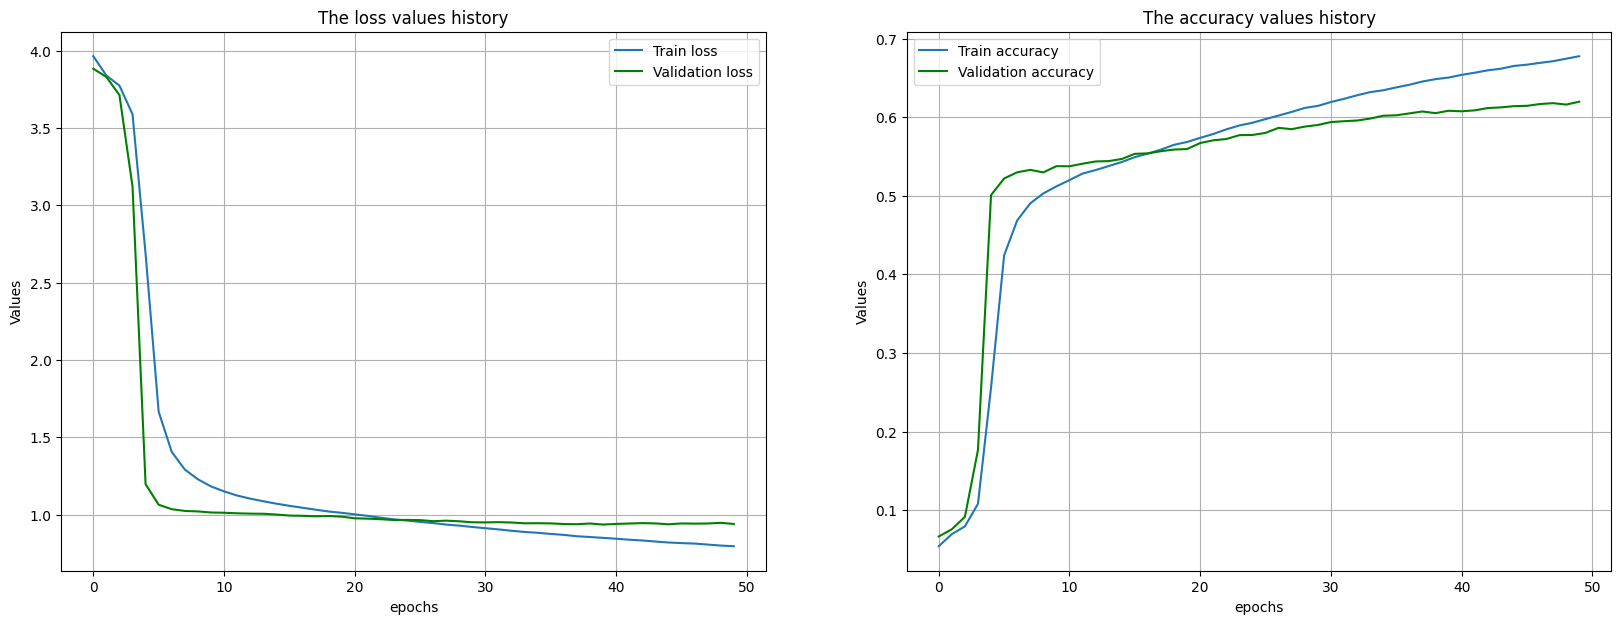

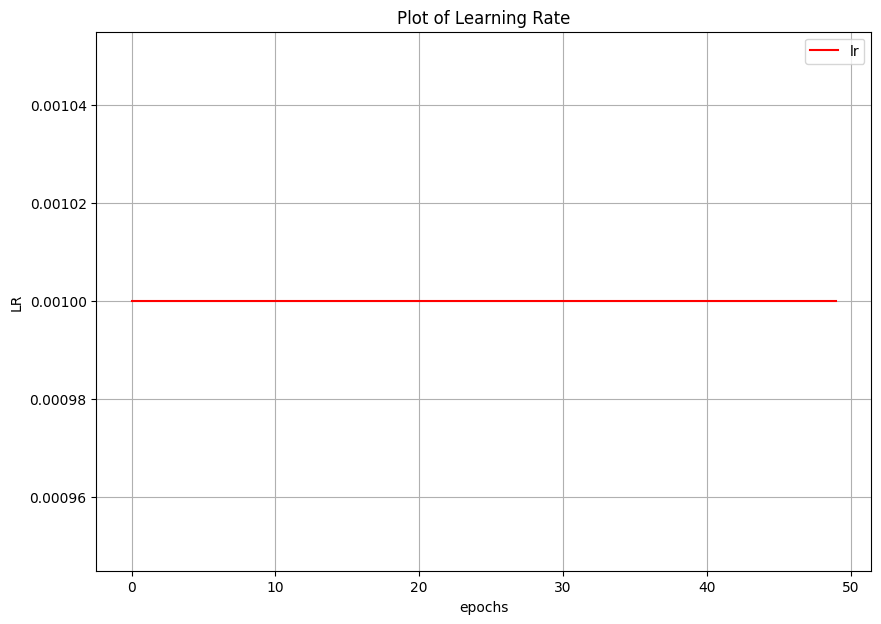

In [8]:
model = Transformer(batch_size=32,
                    epochs=50,
                    embed_size=256,
                    early_stopping_steps=20,
                    min_seq_length=100,
                    max_seq_length=500,
                    num_seq=2000,
                    num_layers=1)

optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=100,cooldown=5)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming pad_token_id is defined

#TRAIN AND EVALUATE THE DATA
train_loss_values,valid_loss_values,train_acc_values,valid_acc_values,lr=model.train_model(optimizer,criterion)
#PLOT CONCLUSIONS
x=np.arange(model.passed_epoch)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))  # Adjust the figure size as needed
#plot loss function values
ax1.plot(x, train_loss_values, label='Train loss')
ax1.plot(x, valid_loss_values, label='Validation loss',color='g')
ax1.set_xlabel('epochs')
ax1.set_ylabel('Values')
ax1.set_title('The loss values history')
ax1.legend(loc='upper right')
ax1.grid(True)

#plot accuracy values
ax2.plot(x, train_acc_values, label='Train accuracy')
ax2.plot(x, valid_acc_values, label='Validation accuracy', color='g')
ax2.set_xlabel('epochs')
ax2.set_ylabel('Values')
ax2.set_title('The accuracy values history')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout to prevent overlap
plt.subplots_adjust(wspace=0.2)
plt.show()

# Plot lr on a separate figure
plt.figure(figsize=(10,7))  # Adjust the figure size as needed
plt.plot(x, lr, label='lr', color='r')
plt.xlabel('epochs')
plt.ylabel('LR')
plt.title('Plot of Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

<h2>step 8- Loading the best model for the test stage</h2>

In [51]:
loading_path=os.path.join(checkpoint_dir, model.model_name)
model.load_checkpoint(loading_path,optimizer)
avg_test_loss, accuracy_test=model.test(model.test_dataloader, criterion)
print(f'average test data loss: {avg_test_loss:.4f}\naccuracy of test dataset: {accuracy_test*100:.4f}%')

C:\Users\farsh\AppData\Local\Temp\ipykernel_30708\4050065207.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


average test data loss: 4.0779
accuracy of test dataset: 3.8647%


<h2>step 9- Error analysis</h2>

plotting the average accuracy of Each Quartile...


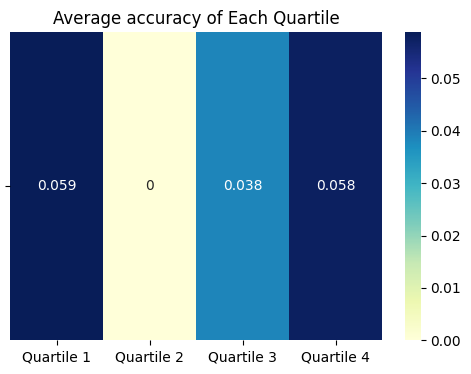


plotting confusion matrix...


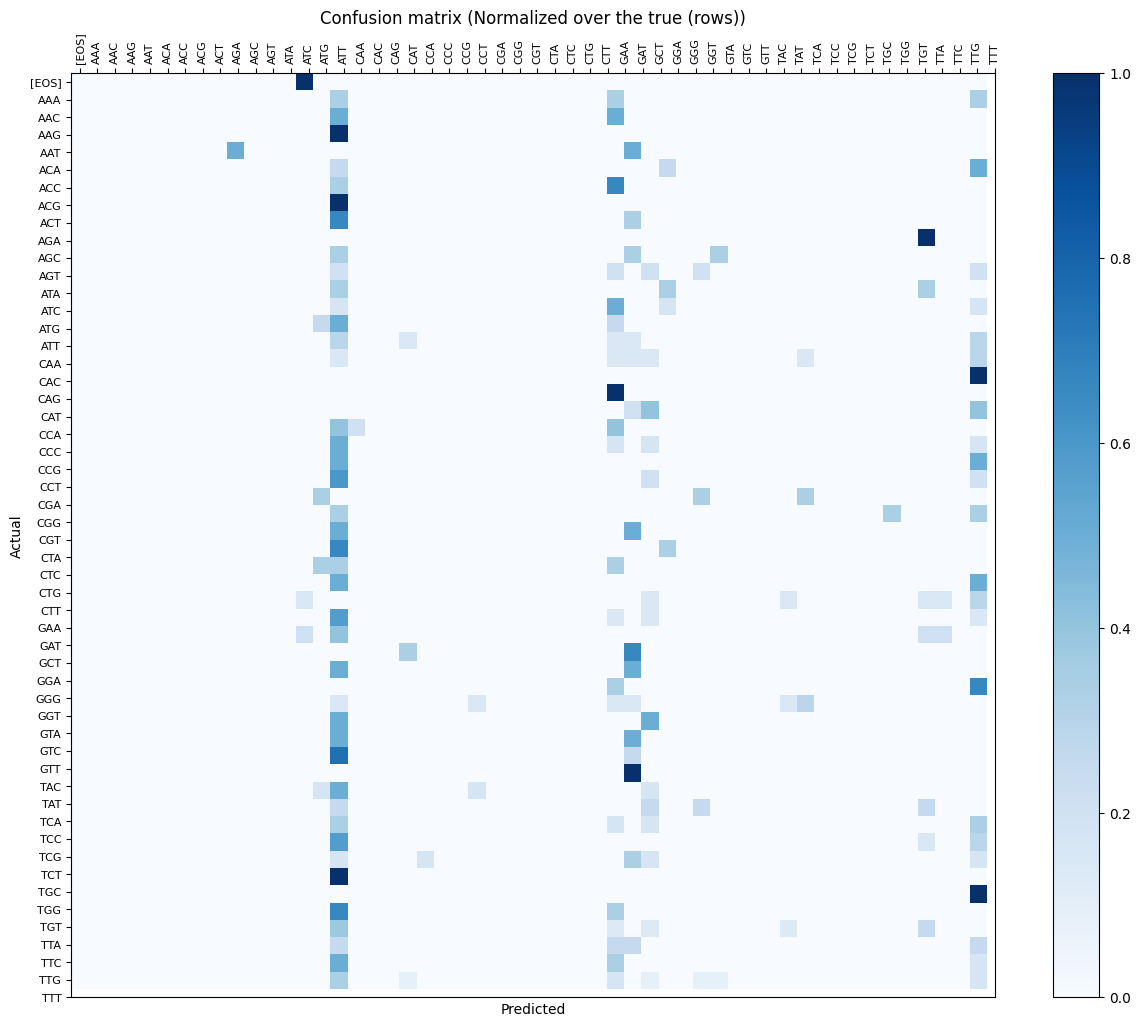


plotting precisin, recall, F1_score table (sorted descending by recall)...
* Precision means how many percentage of the predicted values for that amino acid was predicted correctly
* Recall means how many percentage of the specific amino acid was predicted correctly
* F1-score is the harmonic average of the precision and recall values
**The index numbers correspond to the rows of the confusion matrix for the relevant codons; that's why they have not been reset^^



,Amino acid,Precision,Recall,F1-score,Count
15,ATT,0.03,0.29,0.05,7
14,ATG,0.25,0.25,0.25,4
49,TTA,0.25,0.25,0.25,8
52,TTT,0.06,0.17,0.09,12
31,GAA,0.04,0.14,0.06,7
30,CTT,0.0,0.0,0.0,7
32,GAT,0.0,0.0,0.0,5
33,GCT,0.0,0.0,0.0,3
34,GGA,0.0,0.0,0.0,2
35,GGG,0.0,0.0,0.0,3


In [52]:
sample_acc,substitution,cf_matrix=model.error_analysis(norm_cm='true')

<h2>step 10- The inference stage</h2>

In [28]:
z=model.infer(path_infer)

PREDICTED Codon:
 ATG GTC GAC ACT CCC ATC CTC CCT TCC AAG TTC CTC CAT CTC AAA TGC CTC ACC ATC GAC CAC ACC ATC ATC TCC TCC TCC CCA GCG TAC AAC TAC CTC TAC CTC GTC TAC TTC CTC GAC GCC TGC CCC TCC CTC GAG ACT TTC CTC CTA GGC ATC TCC CAG AAC CAC ATG GAG CAC GAT TCC ATC ATC GGC GAC AGC TCC CAC ATG AGG CAA ATG CCT GGT CAC CGT CAC GAT AAC CTC CGT TCC GTC GAG ATC ACC GGC TTT TAC TCT GCC AAG TCA CTC ATC GAG CTC ACC TGC TAC ATC CTC GAT AAC ACG GTG GCC CTT AAA TAC CTA ACC CTG GAT ACT ACG CGT GGC TTC TTC TCT TGC TCT ACC GGC GAG CAC GAC CGC TGC TTC CCT ATG GAC AAG ATC ATG ATC ACC GAG GCA AAG AGA GCA GTC CTC GCC ATC CAG ACC TAC ATC GAG AGG AAG GTT CCT TCC ACC GTC AAG CTG AAC GTC GTC AAG CCA TGC TCC CGC TGC CAC GCC GTC GAA TCC TAC CTC

The predicted codon sequence has been saved in C:\Users\farsh\GitHub\CodonOptimization\PREDICTED_seq.fasta
--------------------------------------------------
GC content: 56%
--------------------------------------------------
The number of codons that mapped wrongly to 

,Amino acid,Codon,Participation percentage %
0,A,GCC,62.50
1,A,GCA,25.00
2,A,GCG,12.50
3,C,TGC,100.00
4,D,GAC,60.00
5,D,GAT,40.00
6,E,GAG,87.50
7,E,GAA,12.50
8,F,TTC,85.71
9,F,TTT,14.29


<h2>step 11- Codons and amino acids dependency</h2>

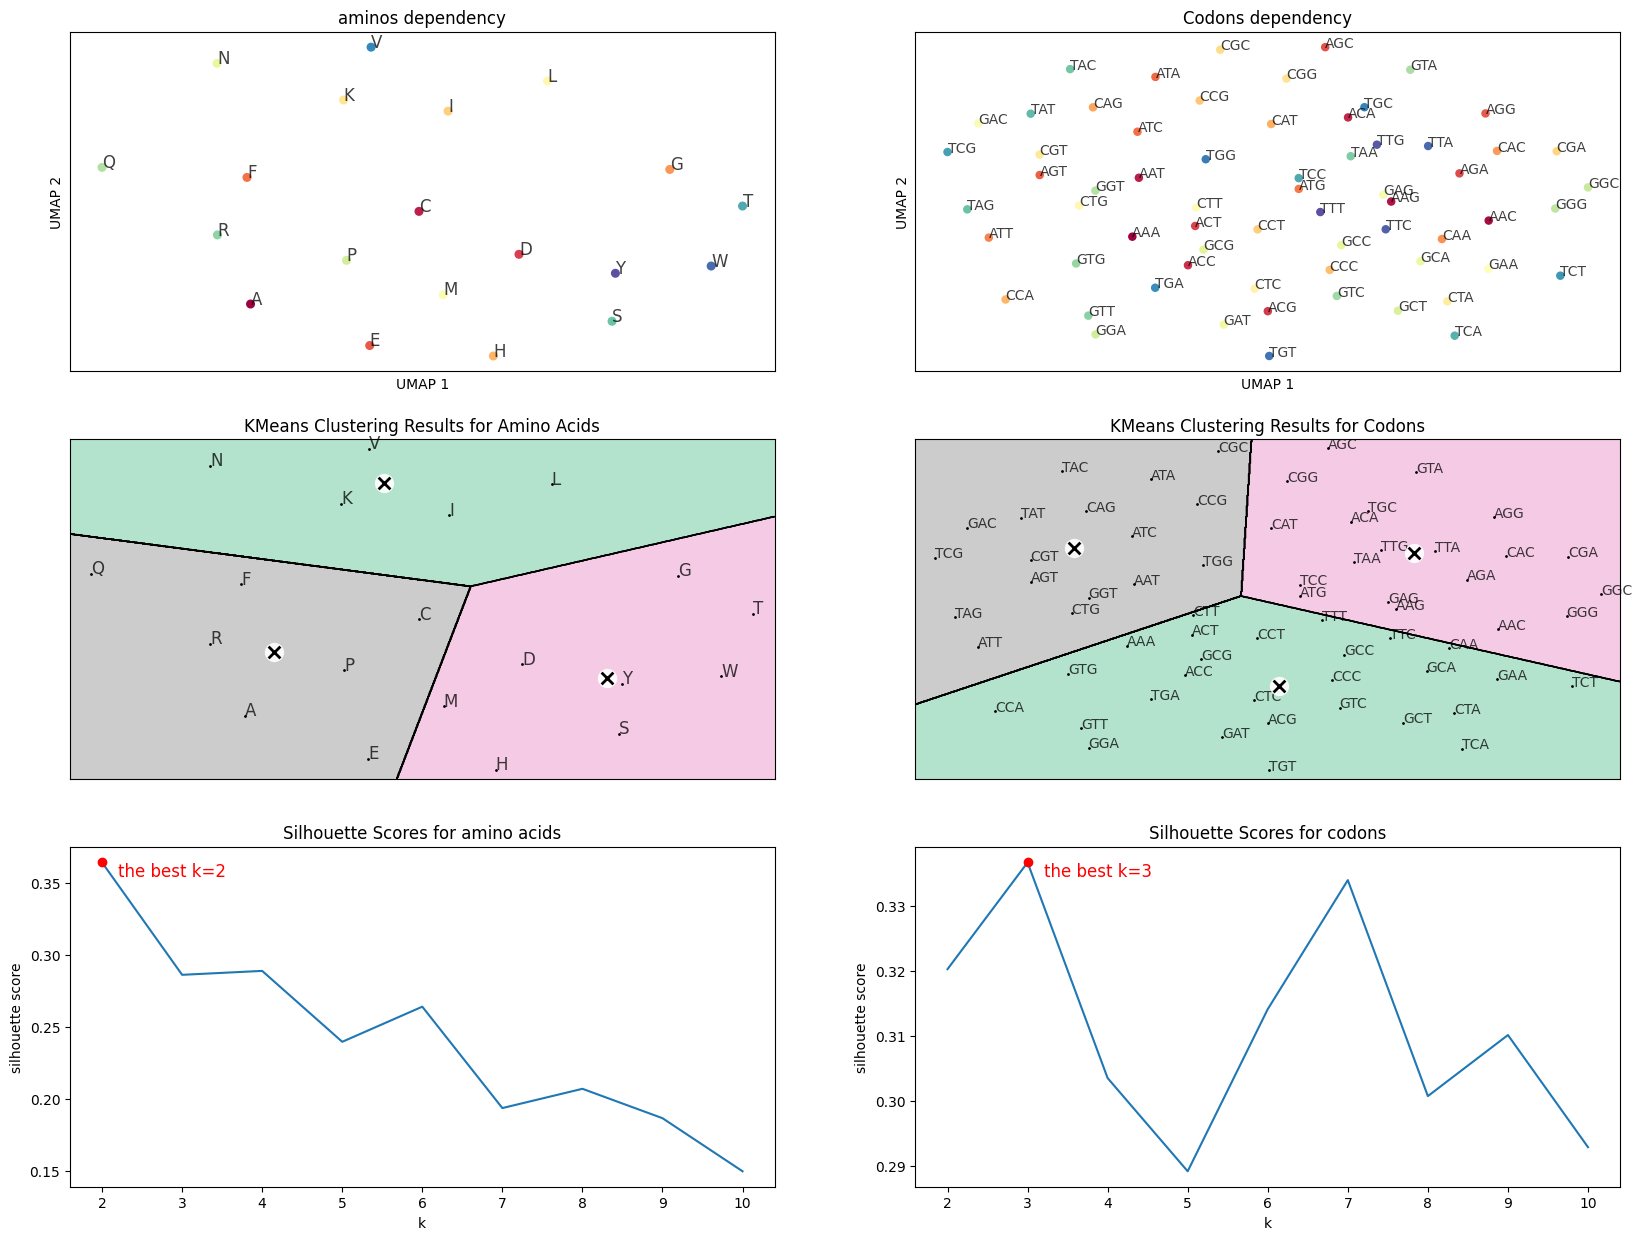

In [17]:
src_embedding=model.state_dict()['src_embedding.token_embeddings.weight']
tgt_embedding=model.state_dict()['tgt_embedding.token_embeddings.weight']
amino_umap,codon_umap=model.plot_umap(src_embedding,tgt_embedding,aa_clusters_num=3,cds_clusters_num=3)